# Cell image segmentation using U-net + Improved Watershed Algorithm

Introduction :

*Cell image segmentation is used on large scale in medical diagnosis. Numerous methods are
available for image segmentation, but they have some limitations. The region-growing
segmentation method is used in the classical model Watershed algorithm. It faults
over-segmentation in the rapid variation of gray level, tightly packed cells, and overlapped cells.
The watershed algorithm works on distance transformation, and improved watersheds can
overcome the problem of cell adhesion, the inner cavity of the cell, and false positive boundaries.
Also, we can use a neural network-based model to precisely detect the cells for accurate
recognition of cells*

The idea of the approach :

*We can get rid of small size, typical, less visible cells in an image given by a microscope using
the U-net algorithm. U-net is CNN based model which requires first training and is good for the
segmentation of images. After recognizing the cells, we need to segment them from the
background. But in many practical cases, separation becomes problematic when the cells
overlap, touch, or are very close to each other. Improved watersheds can separate the object more
accurately than the classical watershed algorithm and can perform well. A combination of these
two algorithms can give the best result, and the entire code will be schemed with GUI to make it
easy to use*

Step 1: First we will use U-net to detect the cells and for segmentation we will use watershed algorithm. In first step we will load and preprocess the dataset. Here I am using **2018 data science bowl dataset** of cells.

In [1]:
# Import all requirements
import os
import cv2
import random
import numpy as np
import tensorflow as tf

from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
from keras.models import load_model
import matplotlib.pyplot as plt

In [2]:
# Data download and unzipping
!wget https://raw.githubusercontent.com/AakashSudhakar/2018-data-science-bowl/master/compressed_files/stage1_test.zip -c
!wget https://raw.githubusercontent.com/AakashSudhakar/2018-data-science-bowl/master/compressed_files/stage1_train.zip -c
# Make two directories
!mkdir train test

# Unzip them
!unzip stage1_train.zip -d train/
!unzip stage1_test.zip -d test/

Streaming output truncated to the last 5000 lines.
  inflating: train/d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0/masks/d86ee01921b1c9ed23c342952253682060512483c39c8b7b5c6d8350f6df2568.png  
  inflating: train/d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0/masks/d8b76279ad8f2e101bb8c5ca95229b6532903eea035ef945dd4a21356d49dead.png  
  inflating: train/d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0/masks/dc05f946c096c5fcc147024843f21c06c3a94af25d4f37b498ea937953b806fe.png  
  inflating: train/d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0/masks/e0fd1c4e98bb470bea315e7d8f74396450fe93e93f68e1f8a3443b2b397c8640.png  
  inflating: train/d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0/masks/e4b6643cafde8ac789b63f7b1a023773960dbe63489963985033619fde052dc9.png  
  inflating: train/d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0/masks/e7e793a1e1785a41a0432a6cd2137be6e1a448bce9f343cfecb493

In [3]:
# Define the image dimensions
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
# Path of directories containing train and test images
TRAIN_PATH = '/content/train/'
TEST_PATH = '/content/test/'
# Generate the file names in a directory tree by walking the tree either top-down or bottom-up                         Alarm
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

# Create two matrix of dimension (None, 128, 128, 3) to store the training data
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

# Now iterate all images path by path. Read , resize and store it into X_train array
print('Please wait! Resizing training images and masks are going on')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img    #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)

    Y_train[n] = mask

# Do the same for test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Resizing test images')
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

<ipython-input-3-72c6a0cc1cc6>:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)


Please wait! Resizing training images and masks are going on


  0%|          | 0/670 [00:00<?, ?it/s]<ipython-input-3-72c6a0cc1cc6>:23: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
100%|██████████| 670/670 [05:12<00:00,  2.15it/s]


Resizing test images


100%|██████████| 65/65 [00:01<00:00, 41.73it/s]

Done!


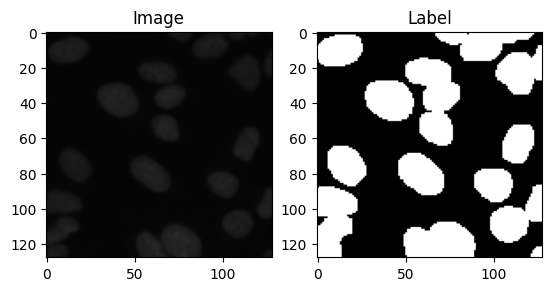

In [4]:
# Just test some random image
image_x = random.randint(0, len(train_ids))
plt.subplot(1, 2, 1)
plt.title('Image')
plt.imshow(X_train[image_x])
plt.subplot(1, 2, 2)
plt.imshow(Y_train[image_x][:,:,0], cmap='gray')
plt.title('Label')
plt.show()

Step 2: Now data is ready and build the U-net model and train it.

In [5]:
# Model architecture
# These layers are same as given by keras
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
# Compile the model using adam optimizer and binary_crossentropy loss
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 lambda (Lambda)             (None, 128, 128, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         448       ['lambda[0][0]']              
                                                                                                  
 dropout (Dropout)           (None, 128, 128, 16)         0         ['conv2d[0][0]']              
                                                                                              

In [6]:
# Modelcheckpoint
#checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]
# Train the model
model.fit(X_train, Y_train, validation_split=0.1, batch_size=1, epochs=2) #, callbacks=callbacks)


Epoch 1/2
603/603 [==============================] - 105s 167ms/step - loss: 0.3376 - accuracy: 0.8491 - val_loss: 0.1330 - val_accuracy: 0.9516
Epoch 2/2
603/603 [==============================] - 100s 165ms/step - loss: 0.1799 - accuracy: 0.9315 - val_loss: 0.1402 - val_accuracy: 0.9490


In [7]:
# Save the model for future use
model.save('cell_model.hdf5')
model.save_weights('cell_model_weight.hdf5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [10]:
# Load the model
model = load_model('/content/cell_model.hdf5')
print('Model Loaded')

Model Loaded


Step 3: Test the model on some random data

In [15]:
# Read the image and rezise it
img = cv2.imread('/content/test/bdc789019cee8ddfae20d5f769299993b4b330b2d38d1218646cf89e77fbbd4d/images/bdc789019cee8ddfae20d5f769299993b4b330b2d38d1218646cf89e77fbbd4d.png')
img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
img = img.reshape(1, 128, 128, 3)

1/1 [==============================] - 0s 51ms/step


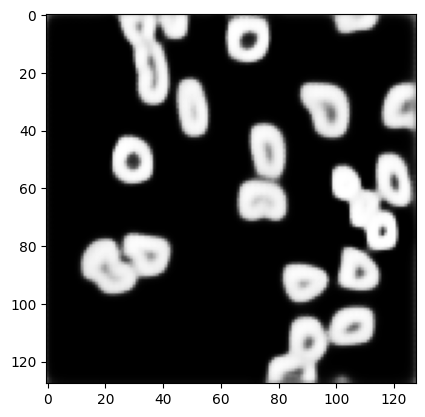

In [16]:
# Feed into the model and plot the output
out = model.predict(img)
temp = out[0,:,:,0]
cv2.imwrite('Ajeet.png', temp)
plt.imshow(temp, cmap='gray')
#out = (out > 0).astype(np.uint8)

Step 4: Now apply Watershed algorithm to segment these images

In [17]:
import cv2
img = cv2.imread('/content/Ajeet.png')  # Read as color (3 channels)
img_grey = img[:,:,0]

## transform the unet result to binary image

ret1, thresh = cv2.threshold(img_grey, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)



kernel = np.ones((2,2),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 1)

sure_bg = cv2.dilate(opening,kernel, iterations=4)

dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)


#Let us threshold the dist transform by starting at 1/2 its max value.
ret2, sure_fg = cv2.threshold(dist_transform, 0.30*dist_transform.max(),255,0)



# Unknown ambiguous region is nothing but bkground - foreground
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

#Now we create a marker and label the regions inside.

ret3, markers = cv2.connectedComponents(sure_fg)


#let us add 10 to all labels so that sure background is not 0, but 10
markers = markers+10

# Now, mark the region of unknown with zero
markers[unknown==255] = 0
#plt.imshow(markers, cmap='gray')   #Look at the 3 distinct regions.

#Now we are ready for watershed filling.
markers = cv2.watershed(img, markers)



Empty DataFrame
Columns: [label, area, equivalent_diameter, mean_intensity, solidity]
Index: []


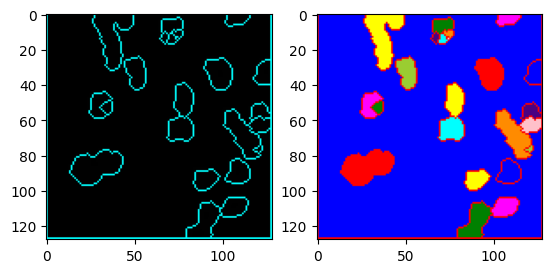

In [18]:
#from google.colab.patches import cv2_imshow
from skimage import measure, color, io
#Let us color boundaries in yellow.
img[markers == -1] = [0,255,255]

img2 = color.label2rgb(markers, bg_label=0)
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(img2)
#cv2.waitKey(0)

#Now, time to extract properties of detected cells
# regionprops function in skimage measure module calculates useful parameters for each object.


props = measure.regionprops_table(markers, intensity_image=img_grey,
                              properties=['label',
                                          'area', 'equivalent_diameter',
                                          'mean_intensity', 'solidity'])
import pandas as pd
df = pd.DataFrame(props)
df = df[df.mean_intensity > 10]  #Remove background or other regions that may be counted as objects

print(df.head())